<a href="https://colab.research.google.com/github/AlexandraLJones/FIRE-CloudComputing/blob/main/Team_Eight_FIRE198WrittenReportTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FIRE 198 Final Report 
##Team 8: Possible Causes of Misclassification in the Deliverable 2 Models 
###Cameron Willette, Sharath Kannan, Percy Olken-Hunt, Kenny Cheung
###Most Recent Update: 5/10/2021



#Introduction


To explain our project, we first must explain Deliverable 2. Deliverable 2 was a student research project in which a supervised model to identify polar lows was created. Firstly, the students collected some images to contribute to a class dataset, taking snapshots of polar lows and non-polar lows and giving each a confidence level regarding their own classification. In addition to the polar low and non-polar low images chosen by students, a set of non-satellite images was also provided to add to the overall collection of data. Next, the data was separated into two independent data sets: a training set and a testing set. Approximately 80% of the images went into the training set, leaving the leftover 20% to go into the testing set. The training set was then imported into Google’s teachable machine to create a trainable model. With the creation of a usable model, students tested the model using the images in the testing set. The model evaluated each image, determining the classification (polar low, non-polar low, or non-satellite image), along with a confidence level (how confident the model is regarding its prediction). The results of the model on the testing sets were recorded for further evaluation and interpretation. A confusion matrix was used to evaluate the model’s predictions for the classifications for each image compared to the student's classifications. The confusion matrix consisted of a 3x3 square, where the x-axis regarded the model’s prediction, and the y-axis regarded the student's classification. Lastly, the students interpreted the model’s accuracy using the results of the confusion matrix.

Our team attempted to find what could be possible causes of misclassification when using a trainable to model to identify images as polar lows, non-polar lows, or non-satellite images such as that from Deliverable 2. The different models from different teams sometimes mislcassified images. Misclassified images negatively impact Deliverable 2's dataset and results, and being able to identify possible causes of such misclassification may lead to future prevention of inaccurate classifications. Also, results from this investigation could prove useful when it comes to analyzing the effectiveness of Google’s Teachable Machine.

Deliverable 2 focuses on polar lows, which is an interesting cloud phenomenon. According to a paper from Oxford Research encyclopedias, polar lows are “intense maritime mesoscale cyclones developing in both hemispheres poleward of the main polar front” (Terpstra & Watanabe, 2020). They often consist of “strong winds, heavy precipitation (hail and snow), and rough sea states”, which can prove to be a threat for “tourism, fisheries, transportation, research activities, and exploration of natural resources,” which is why they are worth studying.

In 2003, a study was able to observe a polar low near Japan using, “all available observational data, including the Geostationary Operational Environmental Satellite (GOES)-9, the Moderate Resolution Imaging Spectroradiometer (MODIS) satellite imagery, the Final Analyses (FNL) data issued by National Centers for Environmental Prediction (NCEP), the surface observational data and the 9-station sounding data of Japan Islands” (Guo et al., 2003). This is a lot of information and tools needed to help observe a polar low. Throughout the years, it has been noted that, “various detection methods typically reveal very different results when applied to a single dataset” (Krinitskiy et al., 2018) for detecting polar lows. Nowadays, machine learning is now one of the main methods for predicting and detecting polar lows. For our data, we use satellite imagery from NASA, human observations, and Google’s Teachable Machine.


#Dependencies








In [ ]:
# Import the required packages. matplotlib, pandas and numpy for graph manipulation, the 
# drive packages for working with Google Drive files, the image packages for image
# manipulation and display, os for file access, and the remaining packages for 
# getting a pandas dataframe representation of a Google Sheet.

import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
import matplotlib.pyplot as plt
import random as ran
import re
import time
from PIL import Image
import tensorflow.keras
from PIL import Image, ImageOps
import numpy as np
import os
import gspread
import cv2

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
from datetime import datetime
!pip install filetype
import filetype
from gspread_dataframe import set_with_dataframe
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())


Mounted at /content/gdrive


#Data


Here we are collecting lists of the file names for images that were correctly classified by the model and images that were misclassified by the model. We also track the actual classification for the misclassified images and the predicted classification. The model used was created by Team 3 for their second deliverable and the image separation was done by Jellyfish Jammers for their second deliverable. The data can all be found on the class shared drive. We specifically used the testing data from the Jellyfish Jammers.

In [ ]:
# The code was written by Cameron Willette.

# Create an array with folder names to access for the different images, a counter
# to track the proper index associated with the folder name, and 2 empty lists
# to store filenames, and classifications for misclassified images, for both
# misclassified and correctly classified images.

folders = ['NonSatelliteTest', 'SnapshotTest', 'NonPolarLowsTest']
misclassified_list = []
correct_list = []
folder_counter = 0

# Track the machine confidence levels for misclassified images in a separate list.
# The order is the same as in the misclassified_list list, i.e. the first value
# here is the value for the first image in misclassified_list, the second value
# is the value for the second image, etc.

machine_confidence_level_list = []

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model, taken from team 3.
model = tensorflow.keras.models.load_model('/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Polar Lows Team Folders/Team 3/keras_model.h5')

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Open each folder in the folders array using the proper directory.
for folder in folders:
    directory = r'/content/gdrive/Shareddrives/FIRE-CC/FIRE198/Polar Lows Team Folders/Jellyfish Jammers/Directories/Test Data/' + folder
    # In each folder, open each file. If the file is an image, open it for analysis.
    for filename in os.listdir(directory):
      if filename.endswith(".jpg") or filename.endswith(".png"):
        image = Image.open(os.path.join(directory, filename))
        size = (224, 224)
        image = ImageOps.fit(image, size, Image.ANTIALIAS)
        image_array = np.asarray(image)
        image_array = image_array[:, :, 0:3]
        image.show()
        normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
        data[0] = normalized_image_array
        # Get the prediction of the image type, which should equal folder counter
        # if the image is correctly classified. If this isn't the case, add the filename
        # to the list of misclassified images, along with the prediction (more specifically,
        # get the number that will be the index for the folders array of the predicted
        # image type). Also update the machine confidence level list. Otherwise, 
        # add the filename to the correct image list.
        prediction = model.predict(data)
        if (folder_counter != np.argmax(prediction)):
          misclassified_list.append(filename)
          misclassified_list.append("Actual: " + str(folder_counter))
          misclassified_list.append("Predicted: " + str(np.argmax(prediction)));
          machine_confidence_level_list.append(prediction[0][np.argmax(prediction)])
        else:
          correct_list.append(filename)
      else:
        continue
    # Increment the folder counter by 1 so the value lines up with the model's
    # predictions.
    folder_counter = folder_counter + 1

The first array below contains information about the mislcassified images, specifically their file name, their actual classification and the machine's predicted classification. The number following actual or predicted represents represents a different image classification. 0 indicates a non-satellite image, 1 indicates a polar low and 2 indicates a non-polar low. The array of floats below that contains the confidence levels given by the machine for its classification. A lower number indicates lower confidence, and a highter number indicates higher confidence. 


In [ ]:
print("List of Misclassified Images: " + str(misclassified_list))
print("List of Machine Confidence Levels for Misclassified Images: " + str(machine_confidence_level_list))

List of Misclassified Images: ['200118_AM5.png', 'Actual: 1', 'Predicted: 2', '190706_JG4.png', 'Actual: 1', 'Predicted: 2', '190702_EB7.png', 'Actual: 1', 'Predicted: 2', '190715_EB2.png', 'Actual: 1', 'Predicted: 2', '200728_DP3.png', 'Actual: 2', 'Predicted: 1', '200219_DC4.png', 'Actual: 2', 'Predicted: 1']
List of Machine Confidence Levels for Misclassified Images: [0.5540531, 0.7736419, 0.9389426, 0.5124867, 0.752869, 0.7886925]


#Methods






###**Visible Pattern in Misclassified Images**

For our first objective, we decided to see if there were any visual patterns between the misclassified images. To do that, we found all the misclassified images from the folder containing all the images and copied them over to our misclassified images folder in our Team Eight folder on Google Drive. Here, we will display the images so we can use them for visual comparison to discern certain patterns.

['200118_AM5.png', '190706_JG4.png', '190702_EB7.png', '190715_EB2.png', '200219_DC4.png', '200728_DP3.png']


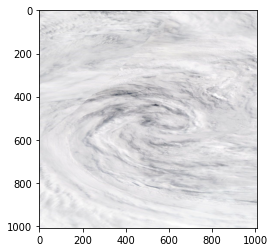

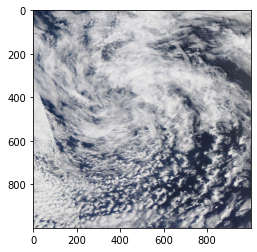

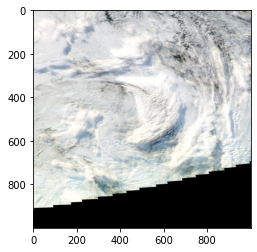

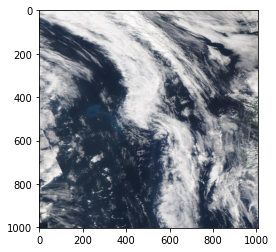

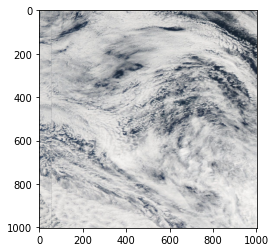

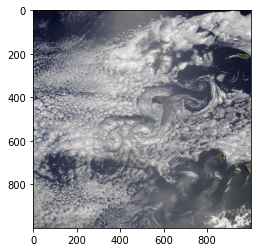

In [ ]:
#displays misclassified images to allow further visible analysis of possible patterns

import os, sys
from IPython.display import Image, display

misclassified_images_path = "/content/gdrive/Shared drives/FIRE-CC/FIRE198/Summative Projects Team Folders/Team Eight/Misclassified Images/"
misclassified_images = os.listdir(misclassified_images_path)

print(misclassified_images) #lists off the names of the misclassified images

img_list = []

for name in misclassified_images: #iterates through each misclassified image, displaying each image
  img = cv2.imread(misclassified_images_path+'/'+name) #THIS CODE ADDED BY DR. JONES
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.show()

 


We recognized a few distinct patterns:

Five out of the six misclassified images have sattelite image-stitching:
*   200118_AM5.png (First image)
*   190706_JG4.png (Second image)
*   190702_EB7.png (Third image)
*   190715_EB2.png (Fourth image)
*   200219_DC4.png (Fifth image)

One can recognize image stitching by distinct lines present within the images. An example of such a line can be seen between around 400 on the y-axis of the second image and 200 on the x-axis.

One of the misclassified images has a clear view of land:
*   200728_DP3.png (Sixth image)

Four out of the six misclassified images have spirals:
*   200118_AM5.png (First image)
*   190706_JG4.png (Second image)
*   190702_EB7.png (Third image)
*   200728_DP3.png (Sixth image)

No non-satellite images were misclassified.

This tells us a few things. Firstly, it seems to indicate that a large source of classification error may come from the picture rather than the model. The first 5 images contain image-stitching and don't offer a clear view of the clouds, and the 6th image has land which we were advised to not include. Image-stitching consists of putting two images together to form one full image; however, a negative byproduct of stitching images together is abnormalities within the image. The satellite images in the training set did not have any shots of land. Secondly, it suggests that polar lows with spiral shapes are less likely to be classified correctly than those with comma shapes. Of the 4 misclassified images that were polar lows, 3 of them had a spiral shape.



###**Correlation of the Confidence Level of the Observer with Misclassfication**


With the second objective we wanted to address was if there was any correlation between the obesrver's confidence level and the misclassification of the images by the machine. Before finding out correlation, it is important to understand what the observer's confidence level means and the process for collecting polar low data.

Using NASA's Terra and Aqua satellite imagery, observers were able to find polar lows on the map and take a snapshot of it. Once found, they labled their finding with a confidence level, coordinates, and the file name of the image on a Google Sheet. For confidence level, a zero means that the observer is positive that the image is not a polar low, a one means that the observer believes the image is a polar low but isn't confident in that belief, and a two means that the observer is positive that the image is a polar low. A score of one or two is used on images labled as a polar low, while a score of zero is used on images labled as a non-polar low.

We wanted to find out whether or not the observer's belief regarding their image's classification has any correlation to misclassification by the image. To do that, we need the images in misclassified_list and the Google Sheet data to figure out the confidence level of those images.  We decided to display our data as a bar chart, with the x axis representing the confidence level of the images and the y axis representing the amount of images. We can use this bar chart to determine which confidence levels resulted in greater amounts of misclassification.






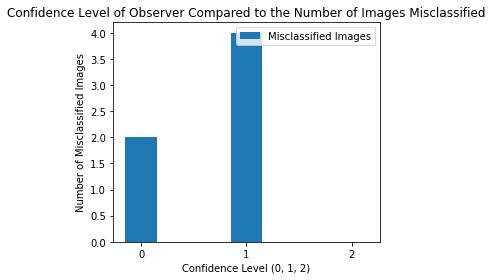

In [ ]:
#Does the "confidence level" of the observer who identified the polar low have 
#any correlation to misclassification? - (Percy Olken-Hunt, Sharath Kannan)
import matplotlib.pyplot as my_plt
import plotly.graph_objects as go


#CODE FOR BAR CHART - Written by Percy
#Manually counted. 6 Misclassified Images. 2 with zero confidence, 
#4 with one confidence, 0 with two confidence.
sizes = [2, 4, 0]

#Confidence score lables.
labels = "0", "1", "2"

#Separate graph to display the same information - possibly easier to understand
x = np.arange(len(labels))
width = 0.3
fig2, ax2 = my_plt.subplots()
rects = ax2.bar(x, sizes, width, label='Misclassified Images')

#Creates graph, customizing lables in the process.
ax2.set_ylabel('Number of Misclassified Images')
ax2.set_xlabel('Confidence Level (0, 1, 2)')
ax2.set_title('Confidence Level of Observer Compared to the Number of Images Misclassified')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
fig2.tight_layout()
plt.show()

According to the data in our bar chart above, there are 2 images with a confidence level of zero, 4 with a confidence level of one, and 0 with a confidence level of 2 that were misclassified. With that, we can confirm that the majority of misclassification occurs with images with a score of one.

By looping through the Google Sheet data, we will now compile a list of confidence levels (user_confidence_score) and a list of image names (image_names). The data in image_names and user_confidence_score wil be calibrated, meaning that if you use the index of a certain name in image_names, the same index in user_confidence_score corresponds to the image's confidence score. We used those lists to make a table for each image using Plotly's table methods so we can easily view some key statistics regarding classification and confidence level. These tables contain the data for the following variables for each image: the user's confidence level, the machine's prediciton, and the actual prediction. The misclassified_list array holds information on a misclassified images' name, actual prediction, and machine's prediction, all in a 1-D array. So, to avoid complexity, the actual prediction and machine prediction, along with the user's confidence score and name, will be put into the table by hand. Information from misclassified_list, user_confidence_score, and image_names are all displayed in text form. From there, they are synthesized into the table format.

In [ ]:
#CODE TO CREATE TABLES - Written by Sharath
#worksheets array contains the names of different workheets on the Polar Lows Google sheets.
worksheets = ["Spring2021", "Spring2020", "Fall2019", "Summer2019"]
user_confidence_score = []
image_names = []

#This loop is originally by Cameron. It is optimzed for use for this objective.
for x in worksheets:
  polarlowlog = gc.open_by_url('https://docs.google.com/spreadsheets/d/1yvsuOAVd0C3-JF7HF3dvb4fbO2t1NjzfFFLWJFYGPPo/edit?usp=sharing').worksheet(x)
  polarlogrows = polarlowlog.get_all_values()
  logdf = pd.DataFrame.from_records(polarlogrows[1:428], columns = polarlogrows[0])
  numpy_info = logdf.to_numpy()
  # Check each row. If the filename is in misclassified_list, increase the count
  # by 1 and the sum by the confidence level. If the filename is in correct_list,
  # do the same for the correct count and sum.
  for i in range(0, (np.size(numpy_info, 0))):
    if numpy_info[i][8] in misclassified_list:
      user_confidence_score.append(numpy_info[i][3])
      image_names.append(numpy_info[i][8])


#The following code takes each of the images and makes a table for it containing
#data for these variables: User Confidence Score, Machine Prediction, and Actual
#Predicition. This is done to help with analysis. Method from Plotly. Refer to: 
#https://plotly.com/python/table/#basic-table
fig = go.Figure(data=[go.Table(header=dict(values=['User Confidence Score', 'Machine Prediction', 'Actual Prediction']),
                 cells=dict(values=[ [1], ["Non-Polar Low"], ["Polar Low"]  ]))
                     ])
#Format table size
fig.update_layout(width=500, height=300)
#Create and format title
fig.update_layout(title_text="200118_AM5.png")
fig.update_layout(title_y=0.8)
fig.update_layout(title_x=0.5)
#Display table
fig.show()

#Now, doing the same thing for the other images:
#200728_DP3.png
fig2 = go.Figure(data=[go.Table(header=dict(values=['User Confidence Score', 'Machine Prediction', 'Actual Prediction']),
                 cells=dict(values=[ [0], ["Polar Low"], ["Non-Polar Low"]  ]))
                     ])
fig2.update_layout(width=500, height=300)
fig2.update_layout(title_text="200728_DP3.png")
fig2.update_layout(title_y=0.8)
fig2.update_layout(title_x=0.5)
fig2.show()

#200219_DC4.png
fig3 = go.Figure(data=[go.Table(header=dict(values=['User Confidence Score', 'Machine Prediction', 'Actual Prediction']),
                 cells=dict(values=[ [0], ["Polar Low"], ["Non-Polar Low"]  ]))
                     ])
fig3.update_layout(width=500, height=300)
fig3.update_layout(title_text="200219_DC4.png")
fig3.update_layout(title_y=0.8)
fig3.update_layout(title_x=0.5)
fig3.show()

#190715_EB2.png
fig4 = go.Figure(data=[go.Table(header=dict(values=['User Confidence Score', 'Machine Prediction', 'Actual Prediction']),
                 cells=dict(values=[ [1], ["Non-Polar Low"], ["Polar Low"]  ]))
                     ])
fig4.update_layout(width=500, height=300)
fig4.update_layout(title_text="190715_EB2.png")
fig4.update_layout(title_y=0.8)
fig4.update_layout(title_x=0.5)
fig4.show()

#190706_JG4.png
fig5 = go.Figure(data=[go.Table(header=dict(values=['User Confidence Score', 'Machine Prediction', 'Actual Prediction']),
                 cells=dict(values=[ [1], ["Non-Polar Low"], ["Polar Low"]  ]))
                     ])
fig5.update_layout(width=500, height=300)
fig5.update_layout(title_text="190706_JG4.png")
fig5.update_layout(title_y=0.8)
fig5.update_layout(title_x=0.5)
fig5.show()

#190702_EB7.png
fig6 = go.Figure(data=[go.Table(header=dict(values=['User Confidence Score', 'Machine Prediction', 'Actual Prediction']),
                 cells=dict(values=[ [1], ["Non-Polar Low"], ["Polar Low"]  ]))
                     ])
fig6.update_layout(width=500, height=300)
fig6.update_layout(title_text="190702_EB7.png")
fig6.update_layout(title_y=0.8)
fig6.update_layout(title_x=0.5)
fig6.show()

 After analyzing all tables thorougly, this is what we can confirm:

*   Images with a confidence score of 1 (200118_AM5.png, 190715_EB2.png, 190706_JG4.png, and 190702_EB7.png) are misclassified as non-polar lows when they are actually polar lows. 
*   Images with a confidence score of 0 (200219_DC4.png and 200728_DP3.png) are misclassified as polar lows when they are actually non-polar lows. 

Relating confidence level to the visual analysis done in the above objective, images with a confidence level of 1 do contain the comma shape of a polar low, but it's either not well defined or hard to detect at first glance. The machine probably misclassified them as non-polar lows for that reason. Images with a confidence level of 0 don't have a difinitive comma shape to them, but rather a scatter of spiral shapes. This is probably what led to the machine misclassifiying them as polar lows, as comma shapes are a defining characteristic of many polar lows. Thus, we can conclude that the observers who mark their image with a confidence 1 are probably at fault for not classifying their image properly, and the machine likely got confused with images with a confidence level of 0 as one of those that was misclassified had spiral shapes similar to those of polar lows.

###**Comparing User Confidence Levels Between Different Image Classifications**

Now we will compare various statistics surrounding the user-made confidence levels between the correctly classified images and the misclassified images. This code finds the different mean confidence levels for the two image types and for the images overall. It also finds the counts of confidence levels for both types of images. It operates by using a numpy representation a Google Sheet along with the lists of correctly classified images and misclassified images. These statistics will allow us to determine whether or not images with a confidence level of 1, indicating uncertainty, are connected to the model's failure (or perhaps the student's failure, the model's classification could be correct), they will allow us to compare the average values to see whether the misclassified images were more likely to have a lower confidence level (though we must be careful here as a 0 confidence level represents a student who was confident that the image was a non-polar low, not a lower confidence), and they will allow us to compare the percentage of correctly classified images per confidence level.

In [ ]:
# Code written by Cameron Willette

# Keep an array of worksheet names, different pages in the Google Sheets, to be
# opened. It's worth noting that the Google Sheets doesn't list non-satellite 
# images, but no non-satellite images were misclassified.
worksheets = ["Spring2021", "Spring2020", "Fall2019", "Summer2019"]

# Keep two arrays that will return the count of each recorded confidence level for
# both correctly classified and misclassified images. The first number is the count
# of images given a confidence level of 0, the second number is the count of images
# given a confidence level of 1 and the third is the count of images given a confidence
# level of 2.
correct_class_list = [0, 0, 0]
misclass_list = [0, 0, 0]

# Start tracking a count of misclassified images and correctly classified images,
# along with a sum of their confidence levels. Also do this for the overall
# images to get a normal average for comparison.
misclass_count = 0
correct_count = 0
misclass_sum = 0
correct_sum = 0
overall_sum = 0
overall_count = 0

# Loop throw and open each worksheet as a pandas dataframe. Turn that dataframe
# into a numpy array.
for x in worksheets:
  polarlowlog = gc.open_by_url('https://docs.google.com/spreadsheets/d/1yvsuOAVd0C3-JF7HF3dvb4fbO2t1NjzfFFLWJFYGPPo/edit?usp=sharing').worksheet(x)
  polarlogrows = polarlowlog.get_all_values()
  logdf = pd.DataFrame.from_records(polarlogrows[1:428], columns = polarlogrows[0])
  numpy_info = logdf.to_numpy()
  # Check each row. If the filename is in misclassified_list, increase the count
  # by 1 and the sum by the confidence level. If the filename is in correct_list,
  # do the same for the correct count and sum. Always update overall count and sum
  for i in range(0, (np.size(numpy_info, 0))):
    if numpy_info[i][8] in misclassified_list:
      misclass_count = misclass_count + 1
      misclass_sum = misclass_sum + int(numpy_info[i][3])
      misclass_list[int(numpy_info[i][3])] += 1
      overall_count = overall_count + 1;
      overall_sum = overall_sum + int(numpy_info[i][3])
    if numpy_info[i][8] in correct_list:
      correct_count = correct_count + 1
      correct_sum = correct_sum + int(numpy_info[i][3])
      correct_class_list[int(numpy_info[i][3])] += 1
      overall_count = overall_count + 1;
      overall_sum = overall_sum + int(numpy_info[i][3])

# Divide the sums by the averages to get the means.
misclass_average = misclass_sum/misclass_count
correct_average = correct_sum/correct_count
overall_average = overall_sum/overall_count

print("Overall Confidence Level Average: " + str(overall_average))
print("Misclassfied Image Human Confidence Level Average: " + str(misclass_average))
print("Correctly Classfied Image Human Confidence Level Average: " + str(correct_average))
print("Misclassified Image Human Confidence Level List (index = confidence level): " + str(misclass_list))
print("Correctly Classified Image Human Confidence Level List (index = confidence level): " + str(correct_class_list))

Overall Confidence Level Average: 1.251231527093596
Misclassfied Image Human Confidence Level Average: 0.6666666666666666
Correctly Classfied Image Human Confidence Level Average: 1.2690355329949239
Misclassified Image Human Confidence Level List (index = confidence level): [2, 4, 0]
Correctly Classified Image Human Confidence Level List (index = confidence level): [39, 66, 92]


Looking at the list of confidence levels, one can again see
that a shocking 0% of images classified as polar lows with a confidence level of 2 were misclassified despite those images making up the biggest chunk of our dataset. The fact that no images that students were confident were polar lows were misclassified while the majority of misclassified images are images that students weren't confident about being polar lows further suggests that perhaps the student could be the source of error rather than the model. We know that the model, which had 100% accuracy in classifying images definitively known to be polar lows, classified those images as non-polar lows, and that the student who classified the images as a polar low wasn't confident. We also know that the model was fairly confident in those classifications from the list of machine confidence levels we have. Given this evidence, it seems more likely that the model's classification is correct.

A roughly even percentage of images given a 1 confidence level and images given a 0 confidence level were misclassified, though the misclassification rate for images given a confidence level of 1 is slightly higher than that of those given a confidence level of 0. This could suggest that maybe the machine used some cloud patterns that weren't unique to polar lows rather than polar low patterns in determining classification, as images that students were confident were non-polar lows were misclassified about as often as images that students thought could be polar lows. 

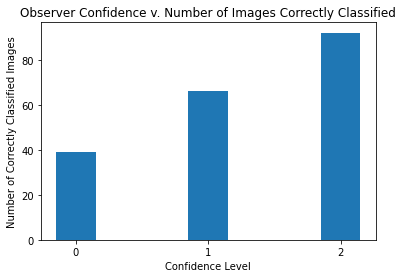

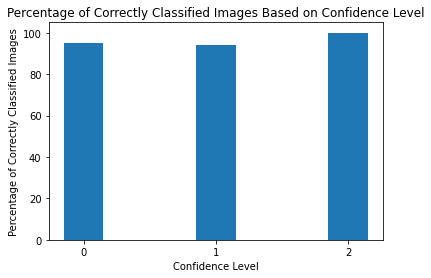

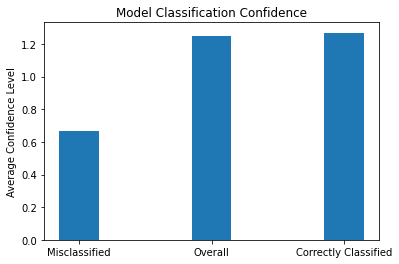

In [ ]:
# Graphing number of correctly classified images based upon 
# observer (student) confidence levels. This code was written by Kenny.
x = np.arange(len(labels))
width = 0.3
fig1, ax1 = my_plt.subplots()
rects = ax1.bar(x, correct_class_list, width)

# Setting labels for the graph.
ax1.set_ylabel('Number of Correctly Classified Images')
ax1.set_xlabel('Confidence Level')
ax1.set_title('Observer Confidence v. Number of Images Correctly Classified')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Graphing percentage of correctly classified images 
# compared to misclassified images.
fig2, ax2 = my_plt.subplots()
percentages = [correct_class_list[0]/(misclass_list[0]+correct_class_list[0])*100,
               correct_class_list[1]/(misclass_list[1]+correct_class_list[1])*100,
               correct_class_list[2]/(misclass_list[2]+correct_class_list[2])*100]
rects = ax2.bar(x, percentages, width)

# Setting labels for the graph.
ax2.set_ylabel('Percentage of Correctly Classified Images')
ax2.set_xlabel('Confidence Level')
ax2.set_title('Percentage of Correctly Classified Images Based on Confidence Level')
ax2.set_xticks(x)

# Graphing average confidence levels for properly 
# classified images, misclassified images, and images overall.
fig3, ax3 = my_plt.subplots()
objects = ('Misclassified', 'Overall','Correctly Classified')
averages = [misclass_average, overall_average, correct_average]
rects = ax3.bar(objects, averages, width)

# Setting labels for the graph.
ax3.set_ylabel('Average Confidence Level')
ax3.set_title('Model Classification Confidence')

plt.show()

As shown above, the average confidence level of misclassified images is significantly lower than that of correctly classified images. Its value lies below 1, while the average confidence level for correctly classified images lies above 1. It's also considerably lower than the average confidence level for images overall. Images given a confidence level of 1 or 2 were considered to be polar lows, and the average for correctly classified images lies between these two values. That average lies slightly above the average confidence level for all images. There are two major things we can take away from this. Firstly, polar lows are seemingly more likely to be correctly classified than non-polar lows. The correct classification average is greater than 1 and even the overall classification average, suggesting a higher proportion of images with confidence level 2 present in correctly classified images than in the overall set. Secondly, this could further suggest that the model found patterns in the polar low images that are more related to clouds themselves than polar lows. That would explain why non-polar low images were misclassified, it could've seen patterns in those images it incorrectly associated with polar lows.



#Conclusions





  To conduct proper research into the potential reasons for misclassification of polar lows, we as a team laid out a series of objectives that we believed to be appropriate in answering our question. Our first objective was to properly identify, label and display images that the Google Teachable Machine misclassified, and then to visually search for oddities and patterns present within that set. Our progress for this objective was extensive as we were able to isolate the six individual images and we were able to conduct visual analysis of their characteristics, finding the presence of lots of spirals and image stitching, along with some land. 
  
  Our next objective was to determine whether student confidence in identifying and submitting polar lows into the class dataset would have any correlation with misclassification rates. By determining the confidence level of the individual misclassified images, we discovered that a majority of them had a confidence level of one. Through our findings we were able to reaffirm our hypothesis that low student confidence in their classificaiton of polar lows would in turn result in higher rates of misclassificiation by the Teachable Machine. As for the remaining misclassified images with a confidence level of zero, we found that one of these images contained spirals which most likely caused the Teachable Machine to misinterpret them as polar lows. 
  
  To build upon this topic, our final objective was to see what relationships there were between the user confidence levels and the accuracy of classification of different images. Our results found that 100% of images with a user confidence level of two were properly classified, further suggesting that lower student confidence in the identification of polar lows leads to misclassification. This is further corroborated by our analysis of average confidence scores for misclassified, overall, and correctly classified images. With the average confidence of misclassified images being significantly less than one, we believe that the model may be incorrectly using patterns present in many clouds, not just polar lows, such as the presence of any spiral shape, to classify images as polar lows. This objective supports our original goal as it helps to determine whether it was mainly students or the Teachable Machine that was the source of misclassification. From our analysis we beleive it is mainly student error that causes the Teachable Machine to produce these misclassifications. It seems that the Teachable Machine may actually be correct in some cases, and in others images with characteristics students were meant to avoid like land presence and image stitching were present. However, we did find some potential errors with the Teachable Machine itself, such as it seemingly interpreting the presence of any spiral pattern whatsoever to mean the image is a polar low.
  
  In summary, our research has indicated the following as possible points for misclassification to occur. Firstly, there are issues regarding student image collection. Student error in collecting images with aforementioned features such as land formations and image stitching is a likely candidate for a source of misclassification. Within the sample of misclassified images, five out of the six images included these errors. We can improve the model in the future by checking to make sure that all of the images submitted by students follow the guidelines and further emphasizing that images with these characteristics aren't valid representations of polar lows or non-polar lows.

What is still left unresolved is what particular components of the Teachable Machine itself are resulting in some misclassification. Mainly, an important question that still needs to be researched is if the Teachable Machine is improperly using characteristics of many clouds rather than just polar lows when classifying images. It seems likely that this may be the case with the spirals present in one of the non-polar lows that were misclassified, but more research should be done to confirm this and to look for other such patterns. We propose that this be a point of interest on future research done regarding this topic. As for future work for Deliverable 2, we want to again reaffirm the importance for future students to take care of their data collection when gathering cloud images to ensure that they run smoothly within the models. 

In order to have improved our research, we believe a larger dataset of images including polar lows, non-polar lows, and non-satellite images would give us a more concrete understanding of the success of the model. With a larger pool of data, we can be sure that the conclusions we arrived at are not influenced by a small dataset and would be expandable. As an example of how this could improve our research, we believe that spiral patterns result in misclassification of non-polar lows as polar lows, though it's hard to definitively declare this with only 2 misclassified non-polar lows.

#Bibliography
Guo, J., Fu, G., Li, Z., Shao, L., Duan, Y., &amp; Wang, J. (2007). Analyses and numerical modeling of a polar low over the Japan Sea on 19 December 2003. Atmospheric Research, 85(3-4), 395–412. https://doi.org/10.1016/j.atmosres.2007.02.007 

Krinitskiy, M., Verezemskaya, P., Grashchenkov, K., Tilinina, N., Gulev, S., &amp; Lazzara, M. (2018). Deep Convolutional Neural Networks Capabilities for Binary Classification of Polar Mesocyclones in Satellite Mosaics. Atmosphere, 9(11), 426. https://doi.org/10.3390/atmos9110426 

Montgomery, M. T., &amp; Farrell, B. F. (1992). Polar Low Dynamics. Journal of the Atmospheric Sciences, 49(24), 2484–2505. https://doi.org/10.1175/1520-0469(1992)049&lt;2484:pld&gt;2.0.co;2 

Terpstra, A., &amp; Watanabe, S.-ichi. (2020). Polar Lows. Oxford Research Encyclopedia of Climate Science. https://doi.org/10.1093/acrefore/9780190228620.013.775 

